In [1]:
''' testing importance sampling and convergence rates'''

' testing importance sampling and convergence rates'

In [1]:
cd ..

/Users/trentonbricken/fem


In [2]:
from models.vae import VAE
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import imresize as resize
import numpy as np
from torchvision import transforms

In [3]:

vae = VAE(3, 32, conditional=True)
best_filename = 'exp_dir/vae/best.tar'

logger_filename = 'exp_dir/vae/'+ 'logger.json'

state = torch.load(best_filename, map_location={'cuda:0': 'cpu'})
print("Reloading vae at epoch {}"
      ", with test error {}".format(
          state['epoch'],
          state['precision']))
vae.load_state_dict(state['state_dict'])

Reloading vae at epoch 26, with test error -1711.404585234375


<All keys matched successfully>

In [4]:
obs_file = 'datasets/downloads_from_server/trimmed_rollout0.npz'

(1000, 84, 96, 3)


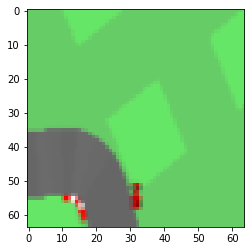

In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


data = np.load(obs_file)

observations = data['observations']
rewards = data['rewards']
print(observations.shape)
ind = 600
obs = transform(observations[ind])
rew = rewards[ind]
plt.figure()
plt.imshow(obs.permute(1,2,0))
plt.show()

In [6]:
obs.shape

torch.Size([3, 64, 64])

## Generating Reconstructions of the Image

In [7]:
from torchvision.utils import save_image
IMAGE_RESIZE_DIM=64
with torch.no_grad():
    last_test_observations = obs.unsqueeze(0)
    last_test_rewards = torch.Tensor([rew]).unsqueeze(0)
    encoder_mu, encoder_logsigma, latent_s, decoder_mu, decoder_logsigma = vae(last_test_observations, last_test_rewards)
    recon_batch = decoder_mu + (decoder_logsigma.exp() * torch.randn_like(decoder_mu))
    recon_batch = recon_batch.view(recon_batch.shape[0], 3, IMAGE_RESIZE_DIM, IMAGE_RESIZE_DIM)
    #sample = torch.randn(IMAGE_RESIZE_DIM, LATENT_SIZE).to(device) # random point in the latent space.  
    # image reduced size by the latent size. 64 x 32. is this a batch of 64 then?? 
    #sample = vae.decoder(sample).cpu()
    decoder_mu = decoder_mu.view(decoder_mu.shape[0], 3, IMAGE_RESIZE_DIM, IMAGE_RESIZE_DIM)
    to_save = torch.cat([last_test_observations.cpu(), recon_batch.cpu(), decoder_mu.cpu()], dim=0)
    print('to save shape', to_save.shape)
    save_image(to_save,
               'notebooks/test_vae_recon' + '.png')


to save shape torch.Size([3, 3, 64, 64])


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Looking at the learnt Sigmas

(array([8.448e+03, 2.648e+03, 6.570e+02, 2.970e+02, 1.410e+02, 5.400e+01,
        1.700e+01, 1.300e+01, 6.000e+00, 7.000e+00]),
 array([2.0814901e-05, 3.7094511e-02, 7.4168205e-02, 1.1124190e-01,
        1.4831559e-01, 1.8538928e-01, 2.2246298e-01, 2.5953668e-01,
        2.9661036e-01, 3.3368406e-01, 3.7075776e-01], dtype=float32),
 <a list of 10 Patch objects>)

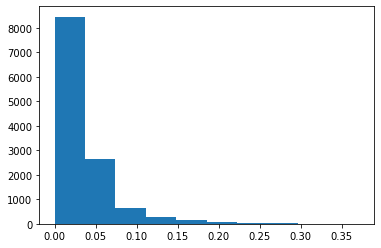

In [8]:
plt.hist(decoder_logsigma.exp().cpu())

In [9]:
sigmas = decoder_logsigma.exp().view(recon_batch.shape[0], 3, 
                            IMAGE_RESIZE_DIM, IMAGE_RESIZE_DIM).squeeze().cpu()
sigmas.shape

torch.Size([3, 64, 64])

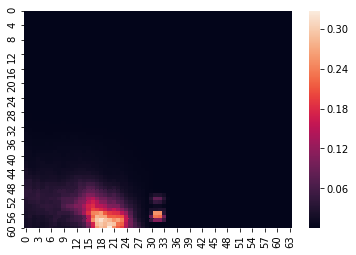

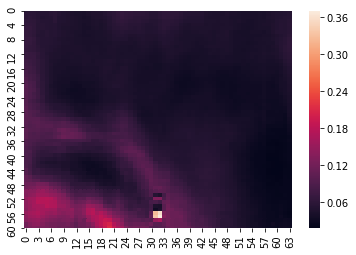

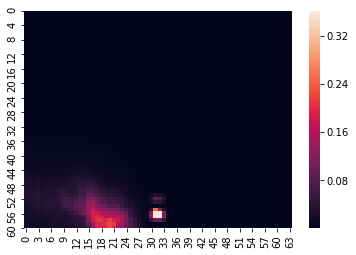

In [10]:
import seaborn as sns
for i in range(3):
    plt.figure()
    ax = sns.heatmap(sigmas[i])
    plt.show()

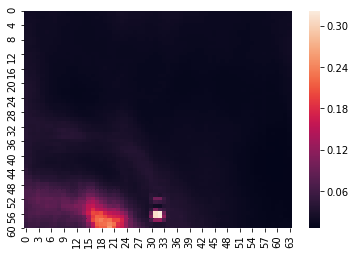

In [11]:
plt.figure()
ax = sns.heatmap(sigmas.mean(dim=0))
plt.show()

## Evaluating estimator efficiency

Using importance sampling. $E_{q(z|x)}[ p(x|z)p(z) / q(z|x) ]$

In [12]:
last_test_observations.shape

torch.Size([1, 3, 64, 64])

In [13]:
last_test_rewards.shape

torch.Size([1, 1])

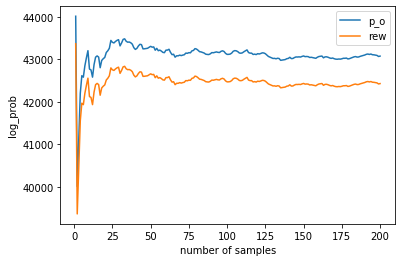

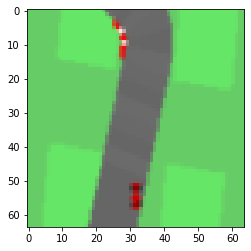

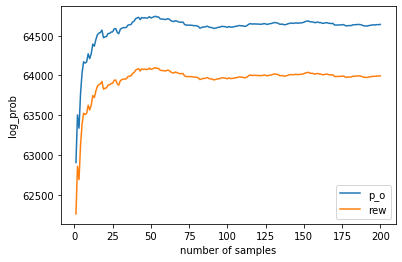

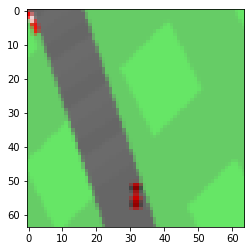

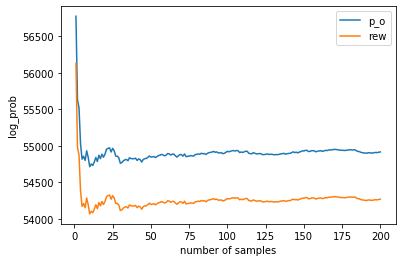

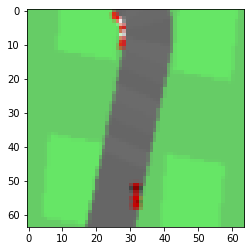

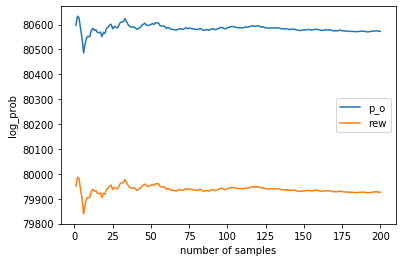

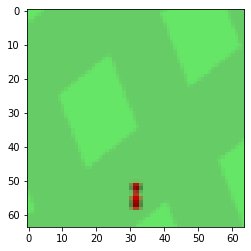

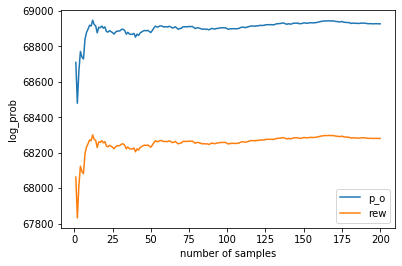

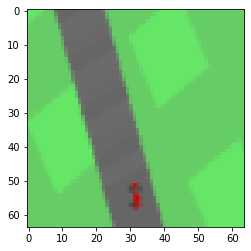

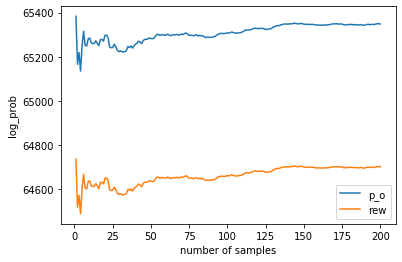

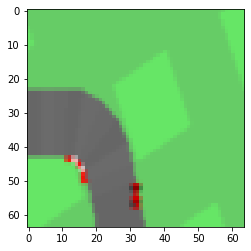

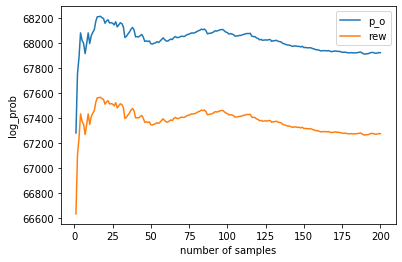

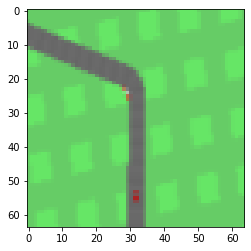

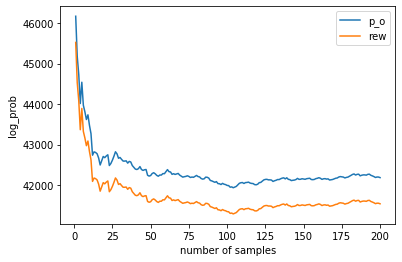

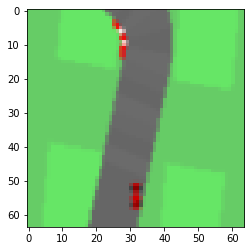

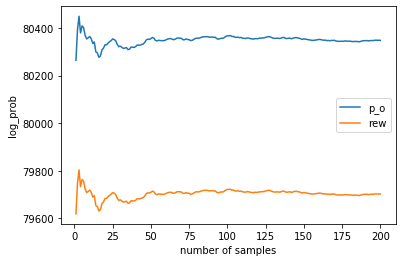

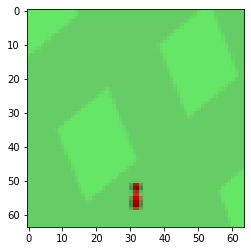

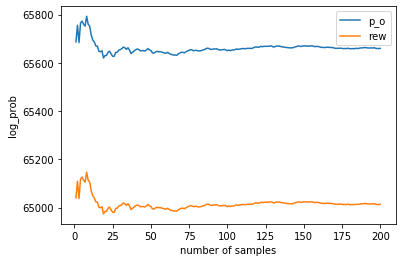

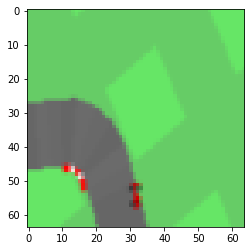

In [49]:

#delta = torch.Tensor([0.000001])
max_samps = 200
rand_inds = np.random.randint(0,1000, 10)
for rand_ind in rand_inds:
    obs = transform(observations[rand_ind])
    rew = rewards[rand_ind]
    last_test_observations = obs.unsqueeze(0)
    last_test_rewards = torch.Tensor([rew]).unsqueeze(0)

    with torch.no_grad():
        p_o = [0.0]
        p_o_rew = [0.0]

        encoder_mu, encoder_logsigma = vae.encoder(last_test_observations, last_test_rewards)

        real_obs = last_test_observations.view(last_test_observations.size(0), -1) # flattening all but the batch.   

        log_p_r = torch.distributions.Normal(3.5, 0.1).log_prob(rew)
        
        def importance_sample( ):

            z = encoder_mu + (encoder_logsigma.exp() * torch.randn_like(encoder_mu))

            decoder_mu, decoder_logsigma = vae.decoder(z, last_test_rewards)

            log_P_OBS_GIVEN_S = torch.distributions.Normal(decoder_mu, decoder_logsigma.exp()).log_prob(real_obs)
            log_P_OBS_GIVEN_S = log_P_OBS_GIVEN_S.sum(dim=-1) #multiply the probabilities within the batch. 

            #log_P_OBS_GIVEN_S = log_P_OBS_GIVEN_S+torch.log(delta)

            log_P_S = torch.distributions.Normal(0.0, 1.0).log_prob(z).sum(dim=-1)
            log_Q_S_GIVEN_X = torch.distributions.Normal(encoder_mu, encoder_logsigma.exp()).log_prob(z).sum(dim=-1)

            #print(log_P_OBS_GIVEN_S, log_P_S, log_Q_S_GIVEN_X)
            return log_P_OBS_GIVEN_S+log_P_S - log_Q_S_GIVEN_X
        
        for i in range(max_samps):

            next_prob = importance_sample()

            p_o.append(p_o[-1]+next_prob) 
            p_o_rew.append(p_o_rew[-1]+next_prob+log_p_r)

        p_o = p_o[1:]
        p_o_rew = p_o_rew[1:]
        p_o = np.array(p_o) / (np.arange(max_samps)+1)
        p_o_rew = np.array(p_o_rew) / (np.arange(max_samps)+1)
        plt.figure()
        plt.plot(np.arange(max_samps)+1, p_o, label='p_o')
        plt.plot(np.arange(max_samps)+1, p_o_rew, label = 'rew')
        plt.xlabel('number of samples')
        plt.ylabel('log_prob')
        plt.legend()
        plt.show()
        
        plt.figure()
        plt.imshow(obs.permute(1,2,0))
        plt.show()
        print('='*10)
        

In [ ]:
# full loss function: 





In [16]:
expand_shape = list(encoder_mu.shape)
expand_shape.append(3)
#expand_shape = torch.Tensor(expand_shape)
expand_shape

[1, 32, 3]

In [17]:
torch.randn(expand_shape).shape

torch.Size([1, 32, 3])

In [18]:
(encoder_logsigma.exp().unsqueeze(-1) * torch.randn(expand_shape)).shape

torch.Size([1, 32, 3])

## Conditional VAE

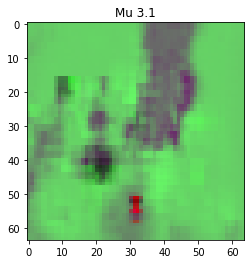

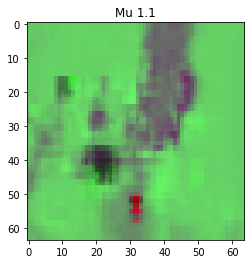

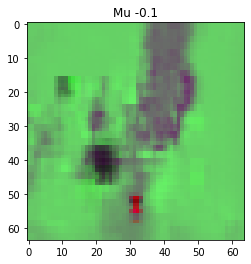

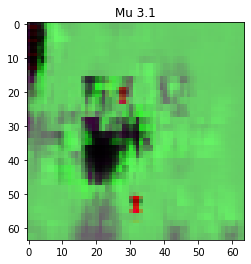

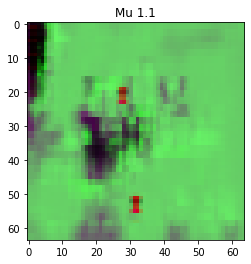

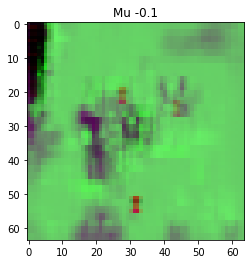

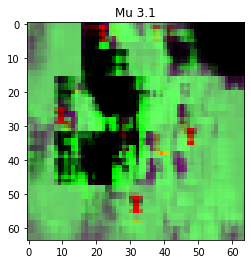

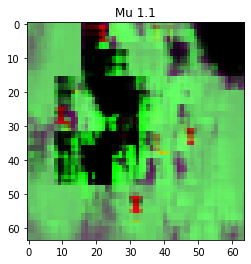

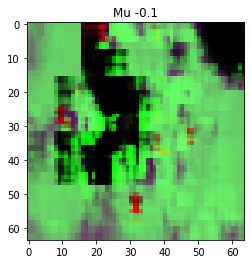

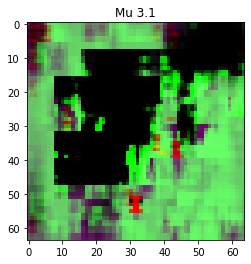

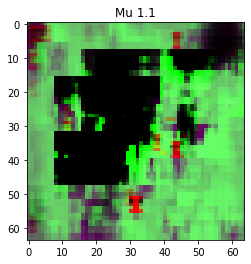

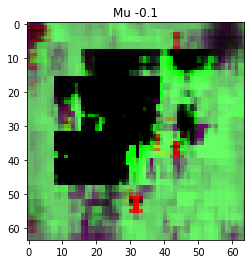

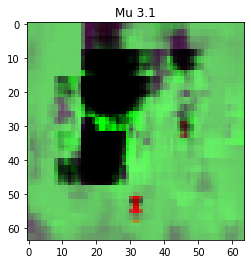

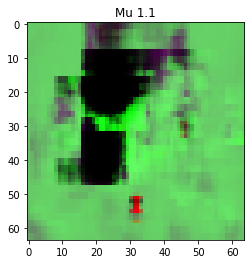

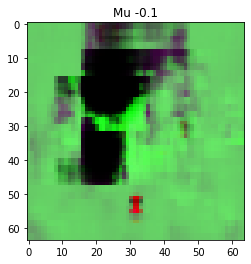

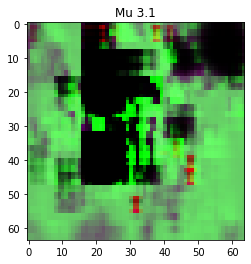

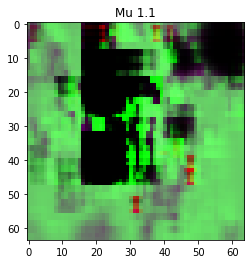

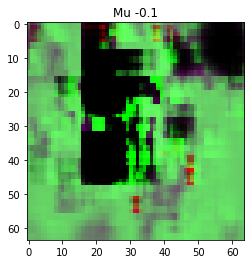

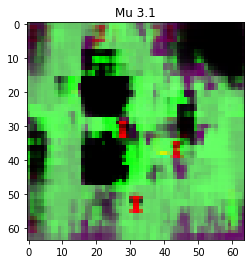

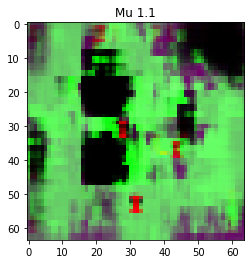

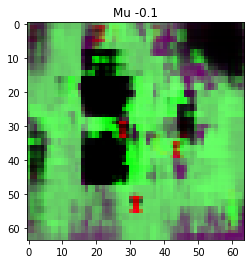

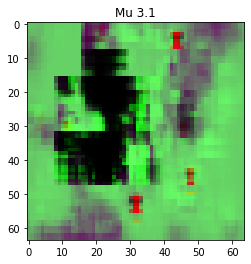

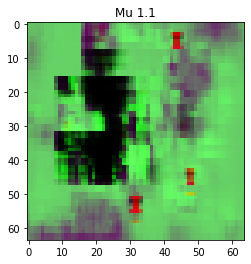

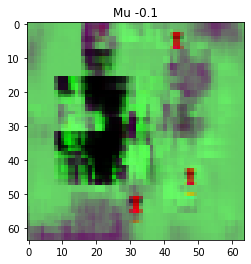

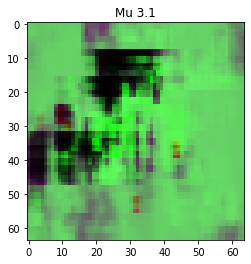

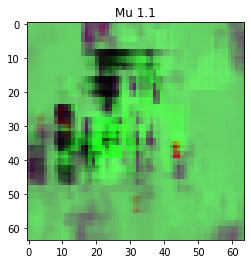

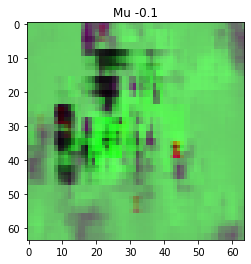

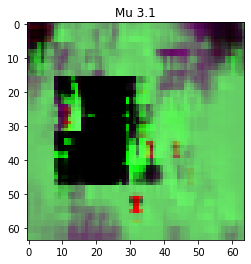

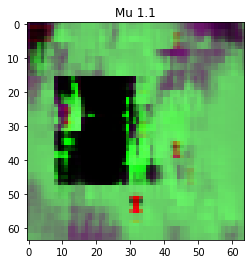

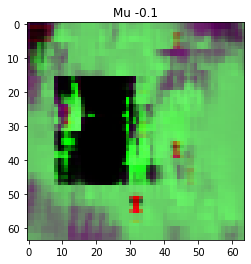

to save shape torch.Size([30, 3, 64, 64])


In [46]:
with torch.no_grad():
    images = []
    for _ in range(10):
        # sample Z from standard normal and condition on different r's. 
        p_z = torch.distributions.Normal(0.0, 1.0)
        z = p_z.sample((1,32))

        cond_reward_high = torch.Tensor([[3.1]])
        cond_reward_mid = torch.Tensor([[1.1]])
        cond_reward_low = torch.Tensor([[-0.1]])
        
        for c_rew in [3.1, 1.1, -0.1]:
            cond_reward = torch.Tensor([[c_rew]])
            

            decoder_mu, decoder_logsigma = vae.decoder(z, cond_reward)

            recon_batch = decoder_mu + (decoder_logsigma.exp() * torch.randn_like(decoder_mu))
            recon_batch = recon_batch.view(recon_batch.shape[0], 3, IMAGE_RESIZE_DIM, IMAGE_RESIZE_DIM)

            decoder_mu = decoder_mu.view(decoder_mu.shape[0], 3, IMAGE_RESIZE_DIM, IMAGE_RESIZE_DIM)

            images.append(decoder_mu.squeeze())
            
            plt.figure()
            plt.title('Mu '+str(c_rew))
            plt.imshow(decoder_mu.squeeze().permute(1,2,0))
            plt.show() 

            '''plt.figure()
            plt.title('sample '+str(c_rew))
            plt.imshow(recon_batch.squeeze().permute(1,2,0))
            plt.show()'''


        print('='*10)
        
    to_save = torch.stack(images) #torch.cat([last_test_observations.cpu(), recon_batch.cpu(), decoder_mu.cpu()], dim=0)
    print('to save shape', to_save.shape)
    save_image(to_save,
               'notebooks/rew_conds' + '.png')


In [32]:
recon_batch

tensor([[[[ 0.3920,  0.3751,  0.3817,  ...,  0.4030,  0.4044,  0.4032],
          [ 0.3954,  0.4035,  0.4085,  ...,  0.4018,  0.4030,  0.4035],
          [ 0.3735,  0.3802,  0.3837,  ...,  0.4010,  0.4019,  0.4008],
          ...,
          [ 0.4107,  0.4079,  0.4101,  ...,  0.4018,  0.4016,  0.3985],
          [ 0.4093,  0.4070,  0.4102,  ...,  0.4018,  0.4020,  0.4023],
          [ 0.4048,  0.4030,  0.4078,  ...,  0.4036,  0.4007,  0.4008]],

         [[ 0.5680,  0.3783,  0.3984,  ...,  0.7408,  0.7423,  0.7594],
          [ 0.4895,  0.2427,  0.2695,  ...,  0.7199,  0.7404,  0.7567],
          [ 0.3582,  0.2949,  0.3701,  ...,  0.7238,  0.7447,  0.7652],
          ...,
          [-0.4604,  0.8436,  0.4242,  ...,  0.7380,  0.7633,  0.7736],
          [ 0.5931,  0.3484,  0.3450,  ...,  0.7208,  0.7509,  0.7613],
          [ 0.2440,  0.9039,  0.4337,  ...,  0.7359,  0.7613,  0.7685]],

         [[ 0.3905,  0.3722,  0.3842,  ...,  0.4035,  0.4042,  0.4048],
          [ 0.3795,  0.3156,  

In [21]:
p_z = torch.distributions.Normal(0.0, 1.0)

tensor([[ 1.0866, -1.2356,  0.9382, -0.6389, -0.2473,  1.2167,  0.7452,  0.4945,
          0.4937, -0.6000, -0.0333,  0.3445,  0.7584, -1.8841,  0.9795,  1.0331,
          1.4259,  0.5901,  0.4809, -1.5622,  0.0326,  2.2125, -1.0095, -0.1993,
         -0.4518,  0.5570, -0.0627, -0.6502,  1.4726,  1.4003,  1.9595,  0.6063]])